Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


<ipython-input-2-3153a2be0f37>:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-2-3153a2be0f37>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/10], Loss: 0.8777
Epoch [2/10], Loss: 0.5363
Epoch [3/10], Loss: 0.4561
Epoch [4/10], Loss: 0.4149
Epoch [5/10], Loss: 0.3866
Epoch [6/10], Loss: 0.3708
Epoch [7/10], Loss: 0.3595
Epoch [8/10], Loss: 0.3479
Epoch [9/10], Loss: 0.3250
Epoch [10/10], Loss: 0.3267
Confusion Matrix:
 [[246  47   3   4]
 [ 23 208  57  18]
 [ 10   6 388   1]
 [  2   9   0 299]]
F1 Score: 0.860566489346571


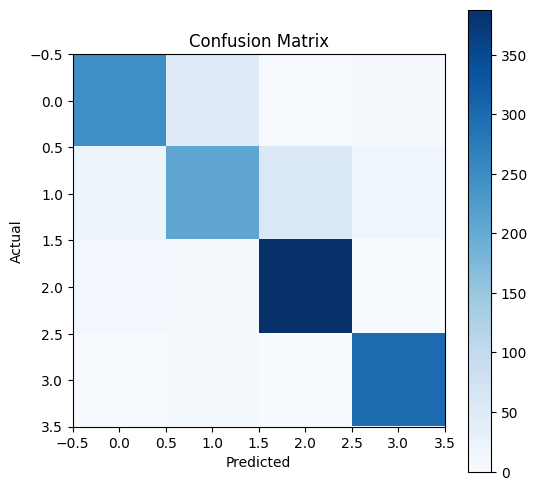

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import numpy as np

# ✅ Mount Google Drive (run once before training)
from google.colab import drive
drive.mount('/content/drive')

# ✅ Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ✅ Hyperparameters
learning_rate = 0.0001
batch_size = 32
dropout_rate = 0.5
epochs = 10
optimizer_type = 'adam'

# ✅ Image transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Corrected dataset paths
train_dir = '/content/drive/My Drive/DLMini/Training'
val_dir = '/content/drive/My Drive/DLMini/Testing'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# ✅ Load ResNet18 with modern weights syntax
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# ✅ Freeze all layers except the final classifier (optional)
for param in model.parameters():
    param.requires_grad = False

# ✅ Replace the final fully connected layer for 4 classes
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(512, 4)  # 4 classes for classification
)

model = model.to(device)

# ✅ Define loss and optimizer
criterion = nn.CrossEntropyLoss()

if optimizer_type == 'adam':
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
elif optimizer_type == 'sgd':
    optimizer = optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=0.9)

# ✅ Mixed Precision Setup
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

# ✅ Training loop with mixed precision
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # ✅ Mixed precision training
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# ✅ Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Confusion matrix and F1 score
cm = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print("Confusion Matrix:\n", cm)
print("F1 Score:", f1)

# ✅ Plot confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

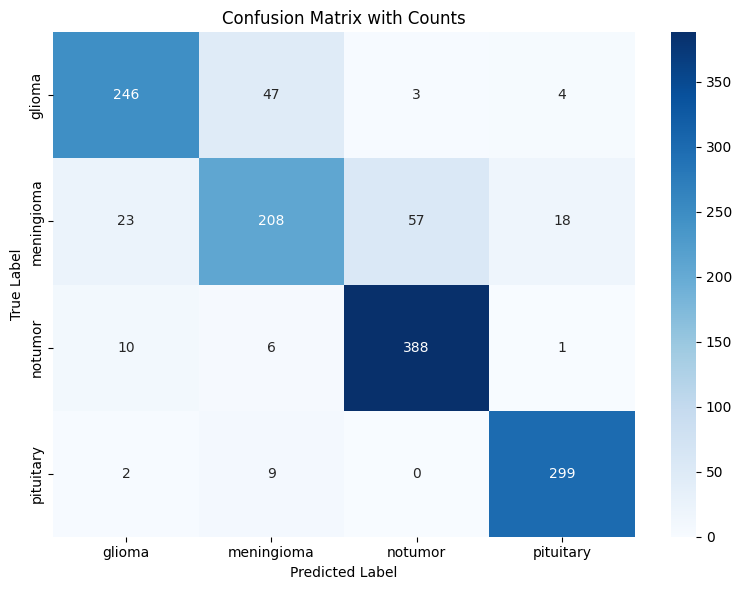

In [ ]:
import seaborn as sns

# ✅ Plot confusion matrix with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.title("Confusion Matrix with Counts")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-6-8d0577498445>:83: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-6-8d0577498445>:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/10], Train Loss: 0.3598, Train Accuracy: 88.02%
Validation Loss: 0.1555, Validation Accuracy: 94.10%
Epoch [2/10], Train Loss: 0.1289, Train Accuracy: 95.42%
Validation Loss: 0.0891, Validation Accuracy: 96.29%
Epoch [3/10], Train Loss: 0.0892, Train Accuracy: 96.89%
Validation Loss: 0.0778, Validation Accuracy: 96.97%
Epoch [4/10], Train Loss: 0.0761, Train Accuracy: 97.34%
Validation Loss: 0.0377, Validation Accuracy: 98.56%
Epoch [5/10], Train Loss: 0.0415, Train Accuracy: 98.64%
Validation Loss: 0.0357, Validation Accuracy: 98.86%
Epoch [6/10], Train Loss: 0.0375, Train Accuracy: 98.74%
Validation Loss: 0.0501, Validation Accuracy: 98.49%
Epoch [7/10], Train Loss: 0.0299, Train Accuracy: 99.08%
Validation Loss: 0.0264, Validation Accuracy: 98.94%
Epoch [8/10], Train Loss: 0.0290, Train Accuracy: 99.10%
Validation Loss: 0.0479, Validation Accuracy: 98.64%
Epoch [9/10], Train Loss: 0.0330, Train Accuracy: 98.93%
Validation Loss: 0.0423, Validation Accuracy: 98.49%
Epoch [10/

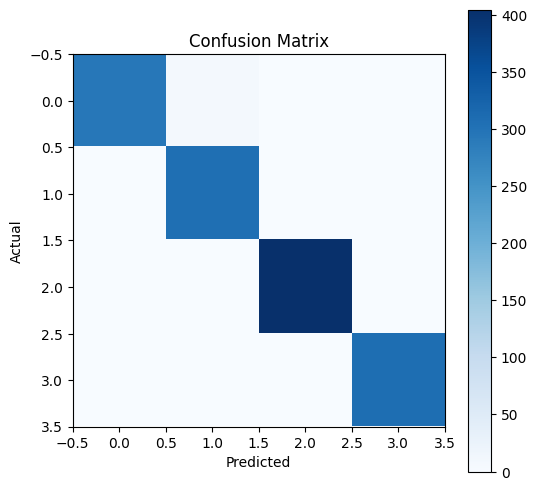

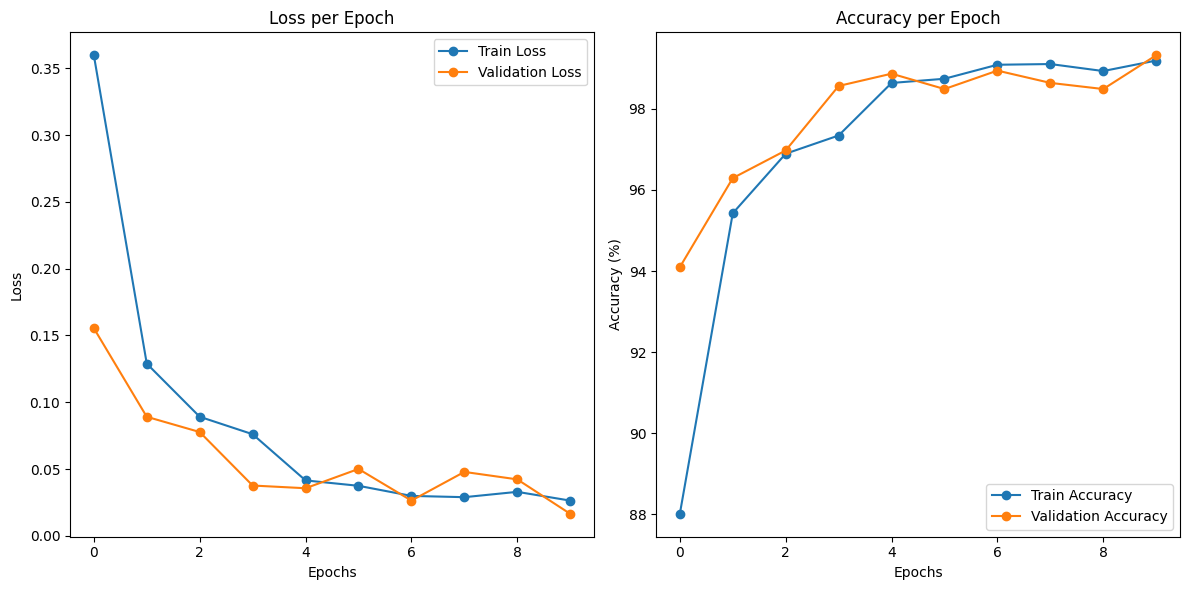

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ✅ Hyperparameters
learning_rate = 0.0001
batch_size = 32
dropout_rate = 0.5
epochs = 10

# ✅ Image transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Dataset paths
train_dir = '/content/drive/My Drive/DLMini/Training'
val_dir = '/content/drive/My Drive/DLMini/Testing'

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# ✅ Load ResNet18 with pretrained weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# ✅ Fine-tune layer4 and fc
for name, param in model.named_parameters():
    param.requires_grad = False  # Freeze all
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True  # Unfreeze final block + classifier

# ✅ Modify classifier
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(512, 4)  # 4 output classes
)

model = model.to(device)

# ✅ Loss function
criterion = nn.CrossEntropyLoss()

# ✅ Optimizer for all trainable layers
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate
)

# ✅ Mixed Precision Setup
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

# ✅ Tracking variables
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# ✅ Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# ✅ Save the model
torch.save(model.state_dict(), '/content/drive/My Drive/DLMini/resnet18_best.pth')

# ✅ Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Metrics
cm = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print("Confusion Matrix:\n", cm)
print("F1 Score:", f1)

# ✅ Classification report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# ✅ Plot confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

# ✅ Plot Loss and Accuracy graphs
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


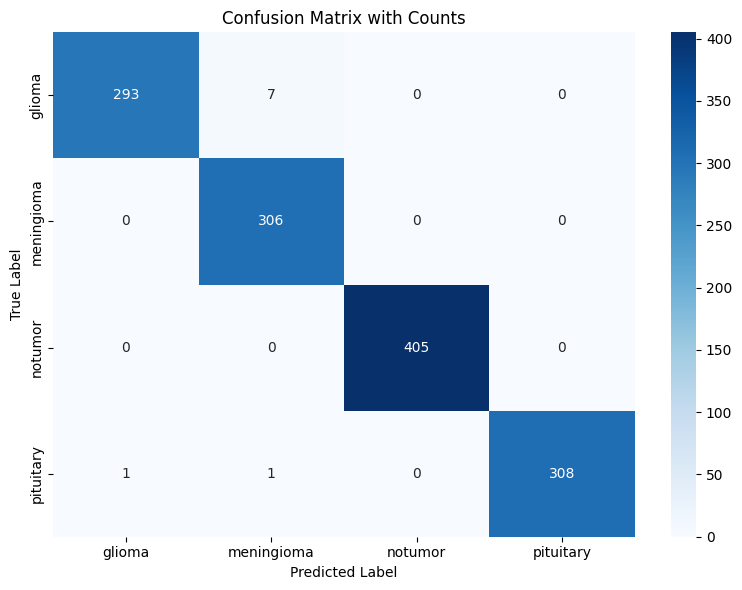

In [ ]:
import seaborn as sns

# ✅ Plot confusion matrix with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.title("Confusion Matrix with Counts")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
